In [1]:
import glob, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopy.distance
import sklearn

### EDA,  Data Preprocessing

In [2]:
data_raw = pd.read_csv('/Users/yul/Desktop/Github Fetch/LA_metro_bike/metro-bike-share-trip-data.csv')

/anaconda3/envs/yulenv/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
data['Distance'] = data.apply(
    (lambda row: geopy.distance.distance(
        (row['Starting Station Latitude'], row['Starting Station Longitude']),
        (row['Ending Station Latitude'], row['Ending Station Longitude'])).miles), axis=1)
ndata = data.drop(['Starting Station Latitude','Starting Station Longitude',
                   'Ending Station Latitude','Ending Station Longitude'], axis=1)
ndata.iloc[:15, :]

,Duration,Start Time,Starting Station ID,Ending Station ID,Plan Duration,Trip Route Category,Passholder Type,Distance
0,180,2016-07-07 04:17:00,3014.0,3014.0,30.0,Round Trip,Monthly Pass,0.000000
1,1980,2016-07-07 06:00:00,3014.0,3014.0,30.0,Round Trip,Monthly Pass,0.000000
2,300,2016-07-07 10:32:00,3016.0,3016.0,365.0,Round Trip,Flex Pass,0.000000
3,10860,2016-07-07 10:37:00,3016.0,3016.0,365.0,Round Trip,Flex Pass,0.000000
4,420,2016-07-07 12:51:00,3032.0,3032.0,0.0,Round Trip,Walk-up,0.000000
5,780,2016-07-07 12:51:00,3021.0,3054.0,30.0,One Way,Monthly Pass,0.441488
6,600,2016-07-07 12:54:00,3022.0,3014.0,30.0,One Way,Monthly Pass,0.763951
7,600,2016-07-07 12:59:00,3076.0,3005.0,365.0,One Way,Flex Pass,0.624177
8,2880,2016-07-07 13:01:00,3031.0,3031.0,365.0,Round Trip,Flex Pass,0.000000
9,960,2016-07-07 13:01:00,3031.0,3078.0,30.0,One Way,Monthly Pass,1.556036


In [47]:
# ndata['Passholder Type'].value_counts() # Number of each passholder types
mask = ndata[ndata['Passholder Type'] == 'Staff Annual'].index
ndata.drop(mask,inplace=True)
ndata['Passholder Type'].value_counts()

Monthly Pass    80519
Walk-up         40743
Flex Pass        9457
Name: Passholder Type, dtype: int64

In [48]:
print(ndata[(ndata['Passholder Type'] == 'Flex Pass') & (ndata['Plan Duration'] == 30.0)])
# We can consider Flex Passes as Annual Passes.

Empty DataFrame
Columns: [Duration, Start Time, Starting Station ID, Ending Station ID, Plan Duration, Trip Route Category, Passholder Type, Distance, Duration_min, Price1, Price2, Price3, Passholder Type_1, Trip Route Category_1]
Index: []


In [49]:
ndata['Duration'] = ndata['Duration'].astype('float')
ndata['Starting Station ID'] = ndata['Starting Station ID'].astype('category')
ndata['Ending Station ID'] = ndata['Ending Station ID'].astype('category')
ndata['Plan Duration'] = ndata['Plan Duration'].astype('category')
ndata['Trip Route Category'] = ndata['Trip Route Category'].astype('category')
ndata['Passholder Type'] = ndata['Passholder Type'].astype('category')
ndata.dtypes

Duration                        float64
Start Time               datetime64[ns]
Starting Station ID            category
Ending Station ID              category
Plan Duration                  category
Trip Route Category            category
Passholder Type                category
Distance                        float64
Duration_min                    float64
Price1                          float64
Price2                          float64
Price3                          float64
Passholder Type_1                 int64
Trip Route Category_1             int64
dtype: object

In [50]:
temp = pd.crosstab(ndata['Starting Station ID'],ndata['Ending Station ID']) # Most popular trip
temp.stack().index[np.argmax(temp.values)]

(3030.0, 3014.0)

In [51]:
temp.iloc[10:15,:15] # The most popular trip counts

Ending Station ID,3005.0,3006.0,3007.0,3008.0,3009.0,3010.0,3011.0,3014.0,3016.0,3018.0,3019.0,3020.0,3021.0,3022.0,3023.0
Starting Station ID,,,,,,,,,,,,,,,
3019.0,53,107,11,22,0,9,30,84,10,23,133,24,11,2,12
3020.0,17,14,3,1,0,2,8,11,0,3,20,132,1,2,0
3021.0,42,22,10,6,0,1,0,69,28,8,5,1,166,79,27
3022.0,130,28,76,16,0,1,1,129,22,13,4,1,110,449,33
3023.0,41,23,20,17,0,1,17,168,147,14,7,6,27,27,310


In [52]:
len(ndata[ndata['Distance']==0]) # Number of Round-Trips

12636

### Check : What criteria customers are choosing each plan

In [54]:
# Assume passengers are following the average duration minutes for each pass.
ndata['Duration_min'] = np.floor(ndata['Duration']/60)
print(ndata.groupby('Passholder Type').mean())

                    Duration  Distance  Duration_min    Price1    Price2  \
Passholder Type                                                            
Flex Pass        1066.689225  1.575642     17.778154  2.787059  1.447059   
Monthly Pass      776.982824  4.261201     12.949714  2.505400  1.165400   
Walk-up          2565.679994  1.016440     42.761333  4.244411  2.904411   

                   Price3  Passholder Type_1  Trip Route Category_1  
Passholder Type                                                      
Flex Pass        1.617059                0.0               0.051073  
Monthly Pass     1.335400                1.0               0.046014  
Walk-up          3.074411                2.0               0.207324  


In [55]:
print(ndata.groupby('Passholder Type').median())

                 Duration  Distance  Duration_min    Price1    Price2  \
Passholder Type                                                         
Flex Pass           600.0  0.707799          10.0  2.333333  0.993333   
Monthly Pass        480.0  0.584102           8.0  2.216667  0.876667   
Walk-up            1140.0  0.604373          19.0  2.858333  1.518333   

                   Price3  Passholder Type_1  Trip Route Category_1  
Passholder Type                                                      
Flex Pass        1.163333                  0                      0  
Monthly Pass     1.046667                  1                      0  
Walk-up          1.688333                  2                      0  


In [109]:
# Probability of taking a ride a day for each Pass
prob_annual = 150/1.75/365
prob_month = 17/1.75/30
prob_daily = 1
print("Annual prob. is %.2f, monthly prob. is %.2f, daily prob. is %.2f"%(prob_annual,prob_month,prob_daily))

# Minimum Utility for buying each Pass a day
util_annual = (1.75*np.ceil(150/1.75))/365
util_month = (1.75*np.ceil(17/1.75))/30
util_daily = 1.75*2 # since the avergae min. is 42.67
print("Annual utility is %.2f, monthly utility is %.2f"%(util_annual,util_month))

print(prob_annual*150)

Annual prob. is 0.23, monthly prob. is 0.32, daily prob. is 1.00
Annual utility is 0.41, monthly utility is 0.58
35.22504892367906


### Calculate the prices of every pass for classification learning 

In [53]:
ndata['Price1'] = 1.75 * (ndata['Duration_min']/30+1) # Price for Walk-up
ndata['Price2'] = 1.75 * ndata['Duration_min']/30+0.41 # Price for Flex Pass
ndata['Price3'] = 1.75 * ndata['Duration_min']/30+0.58 # Price for Monthly Pass

### Random Forest Modeling for current price policy

{'Flex Pass': 0, 'Monthly Pass': 1, 'Walk-up': 2}
{'One Way': 0, 'Round Trip': 1}


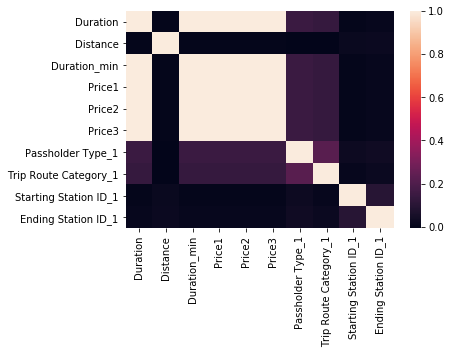

In [74]:
# Random Forest Classification
from sklearn import preprocessing
le1 = preprocessing.LabelEncoder()
le1.fit(ndata['Passholder Type'])
ndata['Passholder Type_1'] = le1.transform(ndata['Passholder Type'])
keys1 = le1.classes_
values1 = le1.transform(le1.classes_)
dictionary1 = dict(zip(keys1, values1))
print(dictionary1)

le2 = preprocessing.LabelEncoder()
le2.fit(ndata['Trip Route Category'])
ndata['Trip Route Category_1'] = le2.transform(ndata['Trip Route Category'])
keys2 = le2.classes_
values2 = le2.transform(le2.classes_)
dictionary2 = dict(zip(keys2, values2))
print(dictionary2)

le3 = preprocessing.LabelEncoder()
le3.fit(ndata['Starting Station ID'])
ndata['Starting Station ID_1'] = le3.transform(ndata['Starting Station ID'])
keys3 = le3.classes_
values3 = le3.transform(le3.classes_)
dictionary3 = dict(zip(keys3, values3))

le4 = preprocessing.LabelEncoder()
le4.fit(ndata['Ending Station ID'])
ndata['Ending Station ID_1'] = le4.transform(ndata['Ending Station ID'])
keys4 = le4.classes_
values4 = le4.transform(le4.classes_)
dictionary4 = dict(zip(keys4, values4))

import seaborn as sns
sns.heatmap(ndata.corr())

In [77]:
pd.DataFrame(ndata.columns)

,0
0,Duration
1,Start Time
2,Starting Station ID
3,Ending Station ID
4,Plan Duration
5,Trip Route Category
6,Passholder Type
7,Distance
8,Duration_min
9,Price1


In [78]:
ndata.dtypes

Duration                        float64
Start Time               datetime64[ns]
Starting Station ID            category
Ending Station ID              category
Plan Duration                  category
Trip Route Category            category
Passholder Type                category
Distance                        float64
Duration_min                    float64
Price1                          float64
Price2                          float64
Price3                          float64
Passholder Type_1                 int64
Trip Route Category_1             int64
Starting Station ID_1             int64
Ending Station ID_1               int64
dtype: object

In [79]:
X = ndata.iloc[:, [7,9,10,11,13,14,15]]
y = ndata.iloc[:, 12]

# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 0)

# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Fitting Random Forest Classification to the Training set
from sklearn.ensemble import AdaBoostClassifier
classifier = AdaBoostClassifier(n_estimators = 500)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)
sc.get_params()
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

/anaconda3/envs/yulenv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/envs/yulenv/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/envs/yulenv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  if sys.path[0] == '':


              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3120
           1       0.73      0.90      0.80     26558
           2       0.69      0.53      0.60     13460

   micro avg       0.72      0.72      0.72     43138
   macro avg       0.47      0.48      0.47     43138
weighted avg       0.66      0.72      0.68     43138



/anaconda3/envs/yulenv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [80]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test,y_pred))

[[    0  2641   479]
 [    0 23856  2702]
 [    0  6278  7182]]


In [101]:
y_pred=pd.DataFrame(y_pred)
y_pred[0].value_counts()

1    32775
2    10363
Name: 0, dtype: int64

### Adapting Random Forest Model for new price policies (1)

In [81]:
# New Minimum Utility for buying each Pass a day
base_price = 4 ; base_time = 60 # in minutes

util_annual = (base_price*np.ceil(150/base_price))/365
util_month = (base_price*np.ceil(17/base_price))/30
util_daily = base_price*2 # since the avergae min. is 42.67
print("Annual utility is %.2f, monthly utility is %.2f"%(util_annual,util_month))

Annual utility is 0.42, monthly utility is 0.67


In [82]:
ndata_scenario1 = ndata.copy()
ndata_scenario1['Price1'] = base_price * (np.floor(ndata_scenario1['Duration_min']/base_time)+1) # Price for Walk-up
ndata_scenario1['Price2'] = base_price * np.floor((ndata_scenario1['Duration_min']/base_time)) + util_annual
# Price for Flex Pass
ndata_scenario1['Price3'] = base_price * np.floor((ndata_scenario1['Duration_min']/base_time)) + util_month
# Price for Monthly Pass

In [83]:
ndata_scenario1.head()

,Duration,Start Time,Starting Station ID,Ending Station ID,Plan Duration,Trip Route Category,Passholder Type,Distance,Duration_min,Price1,Price2,Price3,Passholder Type_1,Trip Route Category_1,Starting Station ID_1,Ending Station ID_1
0,180.0,2016-07-07 04:17:00,3014.0,3014.0,30.0,Round Trip,Monthly Pass,0.0,3.0,4.0,0.416438,0.666667,1,1,7,7
1,1980.0,2016-07-07 06:00:00,3014.0,3014.0,30.0,Round Trip,Monthly Pass,0.0,33.0,4.0,0.416438,0.666667,1,1,7,7
2,300.0,2016-07-07 10:32:00,3016.0,3016.0,365.0,Round Trip,Flex Pass,0.0,5.0,4.0,0.416438,0.666667,0,1,8,8
3,10860.0,2016-07-07 10:37:00,3016.0,3016.0,365.0,Round Trip,Flex Pass,0.0,181.0,16.0,12.416438,12.666667,0,1,8,8
4,420.0,2016-07-07 12:51:00,3032.0,3032.0,0.0,Round Trip,Walk-up,0.0,7.0,4.0,0.416438,0.666667,2,1,23,23


In [102]:
X1 = ndata_scenario1.iloc[:, [7,9,10,11,13,14,15]]
y = ndata.iloc[:, 12]

# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X1_train, X1_test, y_train, y_test = train_test_split(X1, y, test_size = 0.33, random_state = 0)

sc = StandardScaler()
X1_train = sc.fit_transform(X1_train)
X1_test = sc.transform(X1_test)

scenario1 = classifier.predict(X1_test)
from sklearn.metrics import classification_report
print(classification_report(y_test,scenario1))
print(confusion_matrix(y_test,scenario1))

/anaconda3/envs/yulenv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/envs/yulenv/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/envs/yulenv/lib/python3.6/site-packages/ipykernel_launcher.py:10: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  # Remove the CWD from sys.path while we load stuff.


              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3120
           1       0.67      0.90      0.77     26558
           2       0.59      0.33      0.43     13460

   micro avg       0.66      0.66      0.66     43138
   macro avg       0.42      0.41      0.40     43138
weighted avg       0.60      0.66      0.61     43138

[[    0  2699   421]
 [    0 23798  2760]
 [    0  8965  4495]]


/anaconda3/envs/yulenv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [103]:
scenario1=pd.DataFrame(scenario1)
scenario1[0].value_counts()

1    35462
2     7676
Name: 0, dtype: int64

### Adapting Random Forest Model for new price policies (2)

In [104]:
# New Minimum Utility for buying each Pass a day
base_price = 0.5 ; base_time = 10 # in minutes

util_annual = (base_price*np.ceil(150/base_price))/365
util_month = (base_price*np.ceil(17/base_price))/30
util_daily = base_price*2 # since the avergae min. is 42.67
print("Annual utility is %.2f, monthly utility is %.2f"%(util_annual,util_month))

ndata_scenario2 = ndata.copy()
ndata_scenario2['Price1'] = base_price * (np.floor(ndata_scenario2['Duration_min']/base_time)+1) # Price for Walk-up
ndata_scenario2['Price2'] = base_price * np.floor(ndata_scenario2['Duration_min']/base_time) + util_annual
# Price for Flex Pass
ndata_scenario2['Price3'] = base_price * np.floor(ndata_scenario2['Duration_min']/base_time) + util_month
# Price for Monthly Pass

X2 = ndata_scenario2.iloc[:, [7,9,10,11,13,14,15]]
y = ndata.iloc[:, 12]

# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X2_train, X2_test, y_train, y_test = train_test_split(X2, y, test_size = 0.33, random_state = 0)

sc = StandardScaler()
X2_train = sc.fit_transform(X2_train)
X2_test = sc.transform(X2_test)

scenario2 = classifier.predict(X2_test)
from sklearn.metrics import classification_report
print(classification_report(y_test,scenario2))
print(confusion_matrix(y_test,scenario2))

Annual utility is 0.41, monthly utility is 0.57


/anaconda3/envs/yulenv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/envs/yulenv/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/envs/yulenv/lib/python3.6/site-packages/ipykernel_launcher.py:25: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3120
           1       0.74      0.86      0.80     26558
           2       0.65      0.58      0.61     13460

   micro avg       0.71      0.71      0.71     43138
   macro avg       0.46      0.48      0.47     43138
weighted avg       0.66      0.71      0.68     43138

[[    0  2466   654]
 [    0 22903  3655]
 [    0  5603  7857]]


/anaconda3/envs/yulenv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [105]:
scenario2=pd.DataFrame(scenario2)
scenario2[0].value_counts()

1    30972
2    12166
Name: 0, dtype: int64

### Adapting Random Forest Model for new price policies (3)

In [106]:
# New Minimum Utility for buying each Pass a day
base_price = 1.5 ; base_time = 20 # in minutes

util_annual = (base_price*np.ceil(150/base_price))/365
util_month = (base_price*np.ceil(17/base_price))/30
util_daily = base_price*2 # since the avergae min. is 42.67
print("Annual utility is %.2f, monthly utility is %.2f"%(util_annual,util_month))

ndata_scenario3 = ndata.copy()
ndata_scenario3['Price1'] = base_price * (np.floor(ndata_scenario3['Duration_min']/base_time)+1) # Price for Walk-up
ndata_scenario3['Price2'] = base_price * np.floor(ndata_scenario3['Duration_min']/base_time) + util_annual
# Price for Flex Pass
ndata_scenario3['Price3'] = base_price * np.floor(ndata_scenario3['Duration_min']/base_time) + util_month
# Price for Monthly Pass

X3 = ndata_scenario3.iloc[:, [7,9,10,11,13,14,15]]
y = ndata.iloc[:, 12]

# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X3_train, X3_test, y_train, y_test = train_test_split(X3, y, test_size = 0.33, random_state = 0)

sc = StandardScaler()
X3_train = sc.fit_transform(X3_train)
X3_test = sc.transform(X3_test)

scenario3 = classifier.predict(X3_test)
from sklearn.metrics import classification_report
print(classification_report(y_test,scenario3))
print(confusion_matrix(y_test,scenario3))

Annual utility is 0.41, monthly utility is 0.60


/anaconda3/envs/yulenv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/envs/yulenv/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/envs/yulenv/lib/python3.6/site-packages/ipykernel_launcher.py:25: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3120
           1       0.71      0.91      0.80     26558
           2       0.70      0.48      0.57     13460

   micro avg       0.71      0.71      0.71     43138
   macro avg       0.47      0.46      0.46     43138
weighted avg       0.66      0.71      0.67     43138

[[    0  2692   428]
 [    0 24202  2356]
 [    0  7032  6428]]


/anaconda3/envs/yulenv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [107]:
scenario3=pd.DataFrame(scenario3)
scenario3[0].value_counts()

1    33926
2     9212
Name: 0, dtype: int64

In [111]:
# New Minimum Utility for buying each Pass a day
base_price = 1 ; base_time = 15 # in minutes

util_annual = (base_price*np.ceil(150/base_price))/365
util_month = (base_price*np.ceil(17/base_price))/30
util_daily = base_price*2 # since the avergae min. is 42.67
print("Annual utility is %.2f, monthly utility is %.2f"%(util_annual,util_month))

ndata_scenario3 = ndata.copy()
ndata_scenario3['Price1'] = base_price * (np.floor(ndata_scenario3['Duration_min']/base_time)+1) # Price for Walk-up
ndata_scenario3['Price2'] = base_price * np.maximum(0,(np.floor(ndata_scenario3['Duration_min']/base_time)-1)) + util_annual
# Price for Flex Pass
ndata_scenario3['Price3'] = base_price * np.maximum(0,(np.floor(ndata_scenario3['Duration_min']/base_time)-1)) + util_month
# Price for Monthly Pass

X3 = ndata_scenario3.iloc[:, [7,9,10,11,13,14,15]]
y = ndata.iloc[:, 12]

# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X3_train, X3_test, y_train, y_test = train_test_split(X3, y, test_size = 0.33, random_state = 0)

sc = StandardScaler()
X3_train = sc.fit_transform(X3_train)
X3_test = sc.transform(X3_test)

scenario3 = classifier.predict(X3_test)
from sklearn.metrics import classification_report
print(classification_report(y_test,scenario3))
print(confusion_matrix(y_test,scenario3))

Annual utility is 0.41, monthly utility is 0.57


/anaconda3/envs/yulenv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/envs/yulenv/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/envs/yulenv/lib/python3.6/site-packages/ipykernel_launcher.py:25: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3120
           1       0.69      0.95      0.80     26558
           2       0.75      0.38      0.50     13460

   micro avg       0.70      0.70      0.70     43138
   macro avg       0.48      0.44      0.43     43138
weighted avg       0.66      0.70      0.65     43138

[[    0  2839   281]
 [    0 25177  1381]
 [    0  8386  5074]]


/anaconda3/envs/yulenv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [112]:
scenario3=pd.DataFrame(scenario3)
scenario3[0].value_counts()

1    36402
2     6736
Name: 0, dtype: int64

In [114]:
# New Minimum Utility for buying each Pass a day
base_price = 10 ; base_time = 15 # in minutes

util_annual = (base_price*np.ceil(150/base_price))/365
util_month = (base_price*np.ceil(17/base_price))/30
util_daily = base_price*2 # since the avergae min. is 42.67
print("Annual utility is %.2f, monthly utility is %.2f"%(util_annual,util_month))

ndata_scenario3 = ndata.copy()
ndata_scenario3['Price1'] = base_price * (np.floor(ndata_scenario3['Duration_min']/base_time)+1) # Price for Walk-up
ndata_scenario3['Price2'] = base_price * np.maximum(0,(np.floor(ndata_scenario3['Duration_min']/base_time)-1)) + util_annual
# Price for Flex Pass
ndata_scenario3['Price3'] = base_price * np.maximum(0,(np.floor(ndata_scenario3['Duration_min']/base_time)-1)) + util_month
# Price for Monthly Pass

X3 = ndata_scenario3.iloc[:, [7,9,10,11,13,14,15]]
y = ndata.iloc[:, 12]
bn
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X3_train, X3_test, y_train, y_test = train_test_split(X3, y, test_size = 0.33, random_state = 0)

sc = StandardScaler()
X3_train = sc.fit_transform(X3_train)
X3_test = sc.transform(X3_test)

scenario3 = classifier.predict(X3_test)
from sklearn.metrics import classification_report
print(classification_report(y_test,scenario3))
print(confusion_matrix(y_test,scenario3))

Annual utility is 0.41, monthly utility is 0.67


/anaconda3/envs/yulenv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/envs/yulenv/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/envs/yulenv/lib/python3.6/site-packages/ipykernel_launcher.py:25: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3120
           1       0.69      0.95      0.80     26558
           2       0.75      0.38      0.50     13460

   micro avg       0.70      0.70      0.70     43138
   macro avg       0.48      0.44      0.43     43138
weighted avg       0.66      0.70      0.65     43138

[[    0  2839   281]
 [    0 25177  1381]
 [    0  8386  5074]]


/anaconda3/envs/yulenv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
